In [ ]:
# 导入所需要的包，请保证torchvision已经在你的环境中安装好
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import copy

%matplotlib inline

In [3]:
image_size = 28 
num_classes = 20
num_epochs = 10  
batch_size = 64
learning_rate = 0.001

train_dataset = dsets.MNIST(root='./data',  #文件存放路径
                            train=True,   #提取训练集
                            transform=transforms.ToTensor(),  #将图像转化为Tensor
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())


train_dataset0_4 = []
train_dataset5_9 = []
test_dataset0_4 = []
test_dataset5_9 = []


### separate all the traindata and testdata into two parts 
for i in train_dataset:
    if i[1]== 0 or i[1]== 1 or i[1]== 2 or i[1]== 3 or i[1]== 4:
        train_dataset0_4.append(i)
    else:
        train_dataset5_9.append(i)
for i in test_dataset:
    if i[1]== 0 or i[1]== 1 or i[1]== 2 or i[1]== 3 or i[1]== 4:
        test_dataset0_4.append(i)
    else:
        test_dataset5_9.append(i)



In [16]:
train_loader0_4 = torch.utils.data.DataLoader(dataset=train_dataset0_4, 
                                           batch_size=batch_size, 
                                           shuffle=True)
train_loader5_9 = torch.utils.data.DataLoader(dataset=train_dataset5_9, 
                                           batch_size=batch_size, 
                                           shuffle=True)
test_loader0_4 = torch.utils.data.DataLoader(dataset=test_dataset0_4, 
                                          batch_size=batch_size, 
                                          shuffle=True
                                         )
test_loader5_9 = torch.utils.data.DataLoader(dataset=test_dataset5_9, 
                                          batch_size=batch_size, 
                                          shuffle=True
                                         )
train_loader0_9 = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

In [5]:
depth = [4, 8]
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 5, padding = 2) #输入通道为1，输出通道为4，窗口大小为5，padding为2
        self.pool = nn.MaxPool2d(2, 2) #一个窗口为2*2的pooling运算
        self.conv2 = nn.Conv2d(depth[0], depth[1], 5, padding = 2) #第二层卷积，输入通道为depth[0], 输出通道为depth[1]，窗口wei15，padding为2
        self.fc1 = nn.Linear(image_size // 4 * image_size // 4 * depth[1] , 512) #一个线性连接层，输入尺寸为最后一层立方体的平铺，输出层512个节点
        self.fc2 = nn.Linear(512, num_classes) #最后一层线性分类单元，输入为

    def forward(self, x):
        #神经网络完成一步前馈运算的过程，从输入到输出
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # 将立体的Tensor全部转换成一维的Tensor。两次pooling操作，所以图像维度减少了1/4
        x = x.view(-1, image_size // 4 * image_size // 4 * depth[1])
        x = F.relu(self.fc1(x)) #全链接，激活函数
        x = F.dropout(x, training=self.training) #以默认为0.5的概率对这一层进行dropout操作
        x = self.fc2(x) #全链接，激活函数
        x = F.log_softmax(x) #log_softmax可以理解为概率对数值
        return x
    
    def retrieve_features(self, x):
        #提取卷积神经网络的特征图的函数，返回feature_map1, feature_map2为前两层卷积层的特征图
        feature_map1 = F.relu(self.conv1(x))
        x = self.pool(feature_map1)
        feature_map2 = F.relu(self.conv2(x))
        return (feature_map1, feature_map2)
    

In [14]:
def rightness(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，batch_size行10列的矩阵，labels是数据之中的正确答案"""
    pred = torch.max(predictions.data, 1)[1]
    rights = pred.eq(labels.data.view_as(pred)).sum()
    return rights, len(labels) 

net = ConvNet()
criterion = nn.CrossEntropyLoss() #Loss函数的定义
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
record = []
train_loaders = (train_loader0_4,train_loader5_9)

for epoch in range(num_epochs):
    train_rights = [] #记录训练数据集准确率的容器
    for train_loader in train_loaders:
        for batch_idx, (data, target) in enumerate(train_loader):  #针对容器中的每一个批进行循环
            data, target = Variable(data), Variable(target) #将Tensor转化为Variable，data为图像，target为标签
            net.train() # 给网络模型做标记，标志说模型在训练集上训练
            output = net(data) #完成一次预测
            loss = criterion(output, target) #计算误差
            optimizer.zero_grad() #清空梯度
            loss.backward(retain_variables=True) #反向传播
            optimizer.step() #一步随机梯度下降
            right = rightness(output, target) #计算准确率所需数值，返回正确的数值为（正确样例数，总样本数）
            train_rights.append(right) #将计算结果装到列表容器
            
            if batch_idx % 100 == 0: #每间隔100个batch执行一次
                #train_r为一个二元组，分别记录训练集中分类正确的数量和该集合中总的样本数
                train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights])) 
                net.eval() # 给网络模型做标记，标志说模型在训练集上训练
                #打印准确率等数值，其中正确率为本训练周期Epoch开始后到目前撮的正确率的平均值
                print('训练周期: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t训练正确率: {:.2f}%\t'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.data[0], 
                    100. * train_r[0] / train_r[1]))
                
                record.append((100 - 100. * train_r[0] / train_r[1]))
            
            


训练周期: 0 [0/30596 (0%)]	Loss: 2.988874	训练正确率: 4.69%	
训练周期: 0 [6400/30596 (21%)]	Loss: 1.619288	训练正确率: 19.82%	
训练周期: 0 [12800/30596 (42%)]	Loss: 0.708049	训练正确率: 38.25%	
训练周期: 0 [19200/30596 (63%)]	Loss: 0.356134	训练正确率: 54.16%	
训练周期: 0 [25600/30596 (84%)]	Loss: 0.388956	训练正确率: 63.38%	
训练周期: 0 [0/29404 (0%)]	Loss: 13.891346	训练正确率: 68.03%	
训练周期: 0 [6400/29404 (22%)]	Loss: 0.637839	训练正确率: 65.23%	
训练周期: 0 [12800/29404 (43%)]	Loss: 0.401948	训练正确率: 67.44%	
训练周期: 0 [19200/29404 (65%)]	Loss: 0.315030	训练正确率: 69.81%	
训练周期: 0 [25600/29404 (87%)]	Loss: 0.343767	训练正确率: 71.87%	
训练周期: 1 [0/30596 (0%)]	Loss: 10.218905	训练正确率: 0.00%	
训练周期: 1 [6400/30596 (21%)]	Loss: 0.257726	训练正确率: 82.64%	
训练周期: 1 [12800/30596 (42%)]	Loss: 0.081797	训练正确率: 87.93%	
训练周期: 1 [19200/30596 (63%)]	Loss: 0.221090	训练正确率: 89.97%	
训练周期: 1 [25600/30596 (84%)]	Loss: 0.158233	训练正确率: 91.28%	
训练周期: 1 [0/29404 (0%)]	Loss: 9.030615	训练正确率: 91.71%	
训练周期: 1 [6400/29404 (22%)]	Loss: 0.410502	训练正确率: 89.09%	
训练周期: 1 [12800/29404 (43%)]	Loss: 0.40

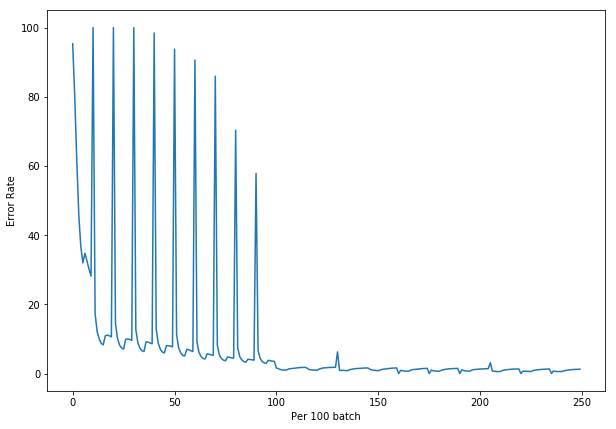

In [29]:
plt.figure(figsize = (10, 7))
plt.plot(record)
plt.xlabel('Per 100 batch')
plt.ylabel('Error Rate')

In [27]:
net1 = ConvNet()
record1 = [] #记录准确率等数值的容器
#开始训练循环
for epoch in range(num_epochs):
    
    train_rights1 = [] #记录训练数据集准确率的容器
    for batch_idx, (data, target) in enumerate(train_loader0_9):  #针对容器中的每一个批进行循环
        data, target = Variable(data), Variable(target) #将Tensor转化为Variable，data为图像，target为标签
        net.train() # 给网络模型做标记，标志说模型在训练集上训练
        output = net(data) #完成一次预测
        loss = criterion(output, target) #计算误差
        optimizer.zero_grad() #清空梯度
        loss.backward() #反向传播
        optimizer.step() #一步随机梯度下降
        right = rightness(output, target)
        #计算准确率所需数值，返回正确的数值为（正确样例数，总样本数）
        train_rights1.append(right) #将计算结果装到列表容器中

    
        if batch_idx % 100 == 0: #每间隔100个batch执行一次
            
            #train_r为一个二元组，分别记录训练集中分类正确的数量和该集合中总的样本数
            train_r = (sum([tup[0] for tup in train_rights1]), sum([tup[1] for tup in train_rights1]))
            
            #打印准确率等数值，其中正确率为本训练周期Epoch开始后到目前撮的正确率的平均值
            print('训练周期: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t训练正确率: {:.2f}%\t'.format(
                epoch, batch_idx * len(data), len(train_loader0_9.dataset),
                100. * batch_idx / len(train_loader0_9), loss.data[0], 
                100. * train_r[0] / train_r[1]))
            
            #将准确率和权重等数值加载到容器中，以方便后续处理
            record1.append((100 - 100. * train_r[0] / train_r[1]))
           
            

训练周期: 0 [0/60000 (0%)]	Loss: 0.028183	训练正确率: 98.44%	
训练周期: 0 [6400/60000 (11%)]	Loss: 0.085991	训练正确率: 98.86%	
训练周期: 0 [12800/60000 (21%)]	Loss: 0.012591	训练正确率: 98.87%	
训练周期: 0 [19200/60000 (32%)]	Loss: 0.011302	训练正确率: 98.85%	
训练周期: 0 [25600/60000 (43%)]	Loss: 0.083240	训练正确率: 98.83%	
训练周期: 0 [32000/60000 (53%)]	Loss: 0.002852	训练正确率: 98.83%	
训练周期: 0 [38400/60000 (64%)]	Loss: 0.021563	训练正确率: 98.85%	
训练周期: 0 [44800/60000 (75%)]	Loss: 0.031110	训练正确率: 98.84%	
训练周期: 0 [51200/60000 (85%)]	Loss: 0.047350	训练正确率: 98.82%	
训练周期: 0 [57600/60000 (96%)]	Loss: 0.043844	训练正确率: 98.79%	
训练周期: 1 [0/60000 (0%)]	Loss: 0.062383	训练正确率: 96.88%	
训练周期: 1 [6400/60000 (11%)]	Loss: 0.060143	训练正确率: 98.82%	
训练周期: 1 [12800/60000 (21%)]	Loss: 0.016123	训练正确率: 98.71%	
训练周期: 1 [19200/60000 (32%)]	Loss: 0.044473	训练正确率: 98.80%	
训练周期: 1 [25600/60000 (43%)]	Loss: 0.014077	训练正确率: 98.80%	
训练周期: 1 [32000/60000 (53%)]	Loss: 0.176461	训练正确率: 98.81%	
训练周期: 1 [38400/60000 (64%)]	Loss: 0.020684	训练正确率: 98.83%	
训练周期: 1 [44800/60000 (75%)

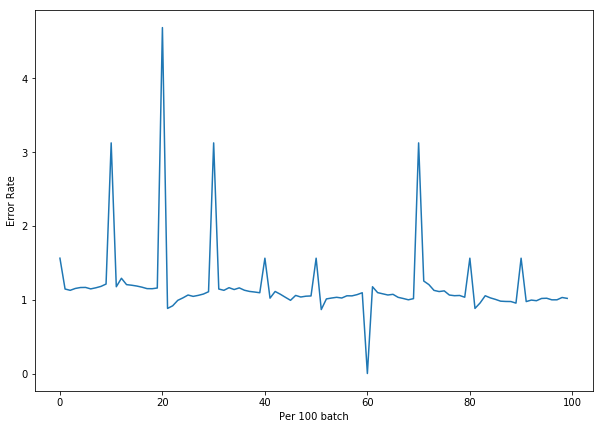

In [30]:
plt.figure(figsize = (10, 7))
plt.plot(record1)
plt.xlabel('Per 100 batch')
plt.ylabel('Error Rate')

In [25]:
net2 = ConvNet()
record2 = []
train_loaders = (train_loader0_4,train_loader0_9)
for epoch in range(num_epochs):
    train_rights = [] #记录训练数据集准确率的容器
    for train_loader in train_loaders:
        for batch_idx, (data, target) in enumerate(train_loader):  #针对容器中的每一个批进行循环
            data, target = Variable(data), Variable(target) #将Tensor转化为Variable，data为图像，target为标签
            net.train() # 给网络模型做标记，标志说模型在训练集上训练
            output = net(data) #完成一次预测
            loss = criterion(output, target) #计算误差
            optimizer.zero_grad() #清空梯度
            loss.backward(retain_variables=True) #反向传播
            optimizer.step() #一步随机梯度下降
            right = rightness(output, target) #计算准确率所需数值，返回正确的数值为（正确样例数，总样本数）
            train_rights.append(right) #将计算结果装到列表容器
            
            if batch_idx % 100 == 0: #每间隔100个batch执行一次
                #train_r为一个二元组，分别记录训练集中分类正确的数量和该集合中总的样本数
                train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights])) 
                net.eval() # 给网络模型做标记，标志说模型在训练集上训练
                #打印准确率等数值，其中正确率为本训练周期Epoch开始后到目前撮的正确率的平均值
                print('训练周期: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t训练正确率: {:.2f}%\t'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.data[0], 
                    100. * train_r[0] / train_r[1]))
                
                record2.append((100 - 100. * train_r[0] / train_r[1]))
            

训练周期: 0 [0/30596 (0%)]	Loss: 0.060087	训练正确率: 98.44%	
训练周期: 0 [6400/30596 (21%)]	Loss: 0.008050	训练正确率: 99.30%	
训练周期: 0 [12800/30596 (42%)]	Loss: 0.005468	训练正确率: 99.40%	
训练周期: 0 [19200/30596 (63%)]	Loss: 0.038710	训练正确率: 99.46%	
训练周期: 0 [25600/30596 (84%)]	Loss: 0.000628	训练正确率: 99.48%	
训练周期: 0 [0/60000 (0%)]	Loss: 0.308002	训练正确率: 99.47%	
训练周期: 0 [6400/60000 (11%)]	Loss: 0.037866	训练正确率: 99.21%	
训练周期: 0 [12800/60000 (21%)]	Loss: 0.174132	训练正确率: 99.07%	
训练周期: 0 [19200/60000 (32%)]	Loss: 0.019771	训练正确率: 99.00%	
训练周期: 0 [25600/60000 (43%)]	Loss: 0.098062	训练正确率: 98.96%	
训练周期: 0 [32000/60000 (53%)]	Loss: 0.005509	训练正确率: 98.91%	
训练周期: 0 [38400/60000 (64%)]	Loss: 0.028777	训练正确率: 98.86%	
训练周期: 0 [44800/60000 (75%)]	Loss: 0.044199	训练正确率: 98.84%	
训练周期: 0 [51200/60000 (85%)]	Loss: 0.084034	训练正确率: 98.82%	
训练周期: 0 [57600/60000 (96%)]	Loss: 0.034409	训练正确率: 98.80%	
训练周期: 1 [0/30596 (0%)]	Loss: 0.010882	训练正确率: 100.00%	
训练周期: 1 [6400/30596 (21%)]	Loss: 0.017849	训练正确率: 99.29%	
训练周期: 1 [12800/30596 (42%)]	Los

训练周期: 9 [25600/60000 (43%)]	Loss: 0.045263	训练正确率: 99.24%	
训练周期: 9 [32000/60000 (53%)]	Loss: 0.019778	训练正确率: 99.18%	
训练周期: 9 [38400/60000 (64%)]	Loss: 0.020437	训练正确率: 99.15%	
训练周期: 9 [44800/60000 (75%)]	Loss: 0.024072	训练正确率: 99.14%	
训练周期: 9 [51200/60000 (85%)]	Loss: 0.032079	训练正确率: 99.13%	
训练周期: 9 [57600/60000 (96%)]	Loss: 0.035783	训练正确率: 99.11%	


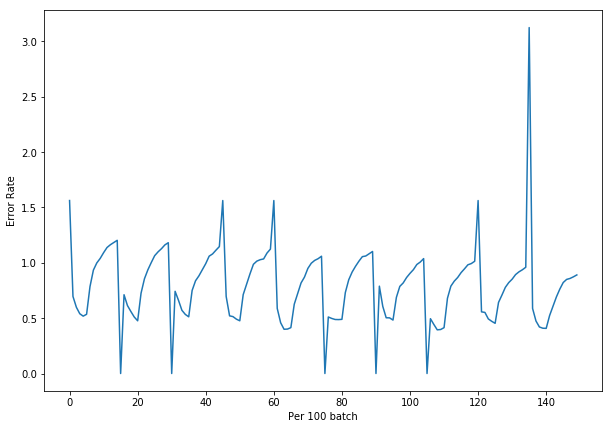

In [31]:
plt.figure(figsize = (10, 7))
plt.plot(record2)
plt.xlabel('Per 100 batch')
plt.ylabel('Error Rate')